# Desafio Grupo ZAP - 07/2019

## Objetivo
 - Um anúncio no portal é composto por diversas características do imóvel, como tamanho, número de quartos, etc. Uma das principais características do imóvel é o seu preço de venda, identificado pelo campo price que, por sua vez, está dentro do campo princingInfos.
 - O objetivo é criar uma maneira automática de estimar um preço de venda para os apartamentos.

## Entregas
- Arquivo csv com os preços dos anúncios com os campos: [id, price]
- Explicação da solução
- Código fonte da solução
- Respostas (com insumos para suporte) para as seguintes questões:
    - Você utilizaria a métrica escolhida para seleção de modelo também para comunicar os resultados para usuários e stakeholders internos? Em caso negativo, qual outra métrica você utilizaria nesse caso?
    - Em quais bairros ou em quais faixas de preço o seu modelo performa melhor?
    - Se você tivesse que estimar o valor dos imóveis com apenas 3 campos, quais seriam eles?
    - Como você vislumbra colocar a sua solução em produção?

# Processo que será seguido

In [1]:
from IPython.display import Image
Image(url = 'images/processo.png')

# Importando as bibliotecas que serão utilizadas neste projeto

In [2]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
#import lightgbm as LGB
from lightgbm import LGBMRegressor
import xgboost as XGB

# Stats
from scipy import stats
from scipy.stats import skew, norm
#from scipy.stats import randint as sp_randint
#from scipy.stats import uniform as sp_uniform

# Misc
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error#, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#!pip install folium
import folium
from folium import plugins

#!pip install pandasql
import pandasql as ps

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

import pickle
import datetime
import re
import gc

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Extraindo e Carregando os Dados

In [3]:
with open('data/source-4-ds-train.json') as file_data:
    data = file_data.readlines()

train = json_normalize([json.loads(d) for d in data])
train.head(3)

,address.city,address.country,address.district,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.locationId,address.neighborhood,address.state,address.street,address.streetNumber,address.unitNumber,address.zipCode,address.zone,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,pricingInfos.rentalTotalPrice,pricingInfos.yearlyIptu,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,Rua Juvenal Galeno,53,,04290030,Zona Sul,3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suíte e closet, sala de esta...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,SALE,NaN,NaN,700000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,Rua Juruaba,16,,04187320,Zona Sul,2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suíte, sala, sala de jantar,...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,SALE,NaN,NaN,336000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0
2,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,Avenida Paulista,402,,01311000,,4.0,0.0,2018-12-18T23:47:03.425Z,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",e7e0b554ac,[http://static.nidoimovel.com.br/d3d9446802a44...,ACTIVE,False,5.0,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,501f6d5e94,0.0,Excelente Conjunto Comercial na Av. Paulista,NaN,COMMERCIAL_PROPERTY,NaN,396.0


Analisando o dataframe, visualizo apenas a coluna imagem aninhada. Json_normalize nos dá algumas dicas sobre como nivelar os dados semi-estruturados. Por enquanto vou remover essa coluna do dataset pra analise do modelo

In [4]:
# Removendo algumas colunas do dataset que identifiquei como não necessárias para o modelo (ex. de colunas unicas)
train.drop(columns = ["images",
                      "address.unitNumber",
                      "address.streetNumber",
                      "description",
                      "id", 
                      "publisherId",
                      "title", 
                      "updatedAt",
                      "address.street"
                     ], inplace = True) 

In [5]:
train.shape

(133964, 28)

In [6]:
train.dtypes

address.city                         object
address.country                      object
address.district                     object
address.geoLocation.location.lat    float64
address.geoLocation.location.lon    float64
address.geoLocation.precision        object
address.locationId                   object
address.neighborhood                 object
address.state                        object
address.zipCode                      object
address.zone                         object
bathrooms                           float64
bedrooms                            float64
createdAt                            object
listingStatus                        object
owner                                  bool
parkingSpaces                       float64
pricingInfos.businessType            object
pricingInfos.monthlyCondoFee        float64
pricingInfos.period                  object
pricingInfos.price                    int64
pricingInfos.rentalTotalPrice       float64
pricingInfos.yearlyIptu         

In [7]:
# Renomeando as colunas para facilitar as analises posteriores
train = train.rename(columns={"address.city": "city",
                              "address.country": "country",
                              "address.district": "district",
                              "address.geoLocation.location.lat": "latitude",
                              "address.geoLocation.location.lon": "longitude",
                              "address.geoLocation.precision": "precision",
                              "address.locationId": "locationId",
                              "address.neighborhood": "neighborhood",
                              "address.state": "state",
                              "address.zipCode": "zipCode",
                              "address.zone": "zone",
                              "pricingInfos.businessType": "businessType",
                              "pricingInfos.monthlyCondoFee": "monthlyCondoFee",
                              "pricingInfos.period": "period",
                              "pricingInfos.price": "price",
                              "pricingInfos.rentalTotalPrice": "rentalTotalPrice",
                              "pricingInfos.yearlyIptu": "yearlyIptu"})

# Análise Exploratória de Dados

In [8]:
# Visualizando as primeiras 5 linhas do dataset de treino
train.head()

,city,country,district,latitude,longitude,precision,locationId,neighborhood,state,zipCode,zone,bathrooms,bedrooms,createdAt,listingStatus,owner,parkingSpaces,businessType,monthlyCondoFee,period,price,rentalTotalPrice,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas
0,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,04290030,Zona Sul,3.0,4.0,2017-02-07T13:21:40Z,ACTIVE,False,6.0,SALE,NaN,NaN,700000,NaN,NaN,STANDARD,1.0,388.0,TWO_STORY_HOUSE,388.0
1,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,04187320,Zona Sul,2.0,3.0,2016-03-21T18:35:17Z,ACTIVE,False,2.0,SALE,NaN,NaN,336000,NaN,NaN,STANDARD,1.0,129.0,HOME,129.0
2,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,01311000,,4.0,0.0,2018-12-18T23:47:03.425Z,ACTIVE,False,5.0,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,0.0,NaN,COMMERCIAL_PROPERTY,396.0
3,São Paulo,,,-23.598023,-46.682781,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,Vila Olímpia,São Paulo,04550004,,2.0,3.0,2018-10-26T16:18:28.915Z,ACTIVE,False,2.0,SALE,686.0,NaN,739643,NaN,1610.0,STANDARD,1.0,80.0,APARTMENT,80.0
4,São Paulo,,,-23.582497,-46.653027,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,Paraíso,São Paulo,04005030,,5.0,4.0,2018-12-14T18:06:51.342Z,ACTIVE,False,5.0,SALE,6230.0,NaN,7520099,NaN,18900.0,STANDARD,4.0,332.0,APARTMENT,3322.0


In [9]:
# Sumário estatístico
train.describe()

,latitude,longitude,bathrooms,bedrooms,parkingSpaces,monthlyCondoFee,price,rentalTotalPrice,yearlyIptu,suites,totalAreas,usableAreas
count,133953.000000,133953.000000,133051.000000,130945.000000,129539.000000,1.171270e+05,1.339640e+05,2.871400e+04,1.146120e+05,120347.000000,9.113200e+04,1.332110e+05
mean,-23.554263,-46.643395,2.375683,2.327023,2.443187,1.507679e+03,6.637484e+05,1.102183e+04,4.182520e+03,1.106534,1.327059e+04,2.204832e+02
std,0.165147,0.318494,2.146044,2.140123,5.251624,7.795406e+04,1.317732e+06,7.701223e+04,8.501091e+05,1.218938,3.682658e+06,5.713502e+03
min,-23.848153,-46.820973,0.000000,0.000000,0.000000,0.000000e+00,7.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,-23.594475,-46.684151,1.000000,2.000000,1.000000,0.000000e+00,1.750000e+05,2.310000e+03,0.000000e+00,0.000000,6.000000e+01,6.000000e+01
50%,-23.558990,-46.654071,2.000000,2.000000,2.000000,3.990000e+02,3.710000e+05,4.111500e+03,8.400000e+01,1.000000,1.200000e+02,1.050000e+02
75%,-23.527634,-46.607885,3.000000,3.000000,3.000000,8.610000e+02,7.000000e+05,9.100000e+03,3.640000e+02,2.000000,2.500000e+02,2.000000e+02
max,0.000000,0.000000,200.000000,600.000000,589.000000,2.443000e+07,8.400000e+07,1.190000e+07,2.830242e+08,80.000000,1.111111e+09,2.025000e+06


Verificando valores missing (valores nulos / faltantes)

In [10]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(train)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:50]

Percent of missing data


[('rentalTotalPrice', 78.57),
 ('period', 78.31),
 ('totalAreas', 31.97),
 ('yearlyIptu', 14.45),
 ('monthlyCondoFee', 12.57),
 ('suites', 10.16),
 ('parkingSpaces', 3.3),
 ('bedrooms', 2.25),
 ('bathrooms', 0.68),
 ('usableAreas', 0.56),
 ('latitude', 0.01),
 ('longitude', 0.01),
 ('precision', 0.01),
 ('city', 0.0),
 ('country', 0.0),
 ('district', 0.0),
 ('locationId', 0.0),
 ('neighborhood', 0.0),
 ('state', 0.0),
 ('zipCode', 0.0),
 ('zone', 0.0),
 ('createdAt', 0.0),
 ('listingStatus', 0.0),
 ('owner', 0.0),
 ('businessType', 0.0),
 ('price', 0.0),
 ('publicationType', 0.0),
 ('unitTypes', 0.0)]

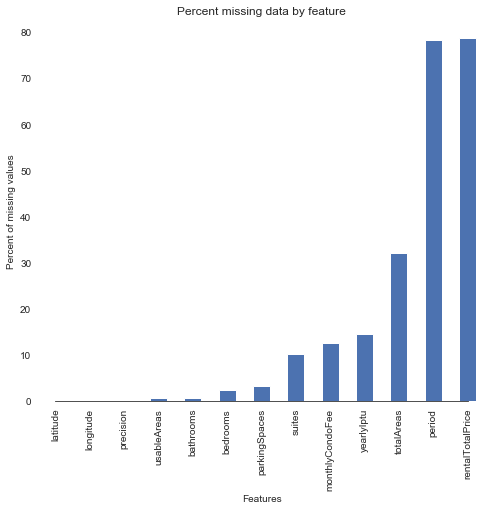

In [11]:
# Setup do plot
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

# Identificando os valores missing
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

# Visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [12]:
# Preenchendo valores em branco (espaco) por valores nulos para serem tratados
train = train.replace(r'^\s*$', np.nan, regex=True)

In [13]:
# Alterando o valor None da variavel zipCode para '00000000'
train['zipCode'] = train['zipCode'].replace('None', '00000000', regex=True)

In [14]:
# Split da coluna 'createAt'
train['createdAt'] = train['createdAt'].apply(lambda x: datetime.datetime.strptime((re.search('\d{4}-\d{2}-\d{2}', x)).group(), '%Y-%m-%d').date())
train['createdAt'] = pd.to_datetime(train['createdAt'])
train['createdAt_day'] = train['createdAt'].dt.day.astype(int)
train['createdAt_month'] = train['createdAt'].dt.month.astype(int)
train['createdAt_year'] = train['createdAt'].dt.year.astype(int)
train['createdAt_weekofyear'] = train['createdAt'].dt.weekofyear.astype(int)
train['createdAt_weekday'] = train['createdAt'].dt.weekday.astype(int)
train['createdAt_weekend'] = (train['createdAt'].dt.weekday >=5).astype(int)
train.drop(columns = ["createdAt"], inplace = True) 

In [15]:
# Split da coluna 'address.locationId'
location = train['locationId'].str.split(">", expand = True) 
train["estado"]= location[3] 
train["bairro"]= location[5] 
train.drop(columns = ["locationId"], inplace = True) 

In [16]:
# Funcao para tratar os dados missing de cada variavel
def fill_na(data):
    data['rentalTotalPrice'].fillna(0,inplace=True)
    data['monthlyCondoFee'].fillna(0,inplace=True)
    data['period'].fillna('NONE',inplace=True)
    data['yearlyIptu'].fillna(0,inplace=True)
    data['country'].fillna('BR',inplace=True)
    data['district'].fillna('None',inplace=True)
    data['zone'].fillna('None',inplace=True)
    data['zipCode'].fillna('None',inplace=True)
    data['state'].fillna('SP',inplace=True)
    data['estado'].fillna('Sao Paulo',inplace=True)
    data['neighborhood'].fillna('None',inplace=True)
    data['bairro'].fillna('None',inplace=True)
    data['suites'].fillna(0,inplace=True)
    data['parkingSpaces'].fillna(data['parkingSpaces'].mode()[0],inplace=True)
    data['bedrooms'].fillna(data['bedrooms'].mode()[0],inplace=True)
    data['bathrooms'].fillna(data['bathrooms'].mode()[0],inplace=True)
    data['totalAreas'].fillna(data['totalAreas'].mode()[0],inplace=True)
    data['usableAreas'].fillna(data['usableAreas'].mode()[0],inplace=True)
    data['latitude'].fillna(0,inplace=True)
    data['longitude'].fillna(0,inplace=True)
    data['precision'].fillna('NO_GEOCODE',inplace=True)    

In [17]:
# Chamando a funcao para tratamento dos dados missing no dataset de treino
fill_na(train)

In [18]:
# Convertendo algumas variaveis  para inteiro
train['bathrooms'] = train['bathrooms'].astype(int)
train['bedrooms'] = train['bedrooms'].astype(int)
train['parkingSpaces'] = train['parkingSpaces'].astype(int)
train['suites'] = train['suites'].astype(int)

In [19]:
# Fazendo uma limpeza na memoria
gc.collect()

159

In [20]:
# Verificando as 5 primeiras linhas do nosso dataset
train.head(5)

,city,country,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,listingStatus,owner,parkingSpaces,businessType,monthlyCondoFee,period,price,rentalTotalPrice,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,estado,bairro
0,São Paulo,BR,None,-23.612923,-46.614222,ROOFTOP,Jardim da Saúde,São Paulo,04290030,Zona Sul,3,4,ACTIVE,False,6,SALE,0.0,NONE,700000,0.0,0.0,STANDARD,1,388.0,TWO_STORY_HOUSE,388.0,7,2,2017,6,1,0,Sao Paulo,Jardim da Saude
1,São Paulo,BR,None,-23.643962,-46.593475,RANGE_INTERPOLATED,Vila Santa Teresa (Zona Sul),São Paulo,04187320,Zona Sul,2,3,ACTIVE,False,2,SALE,0.0,NONE,336000,0.0,0.0,STANDARD,1,129.0,HOME,129.0,21,3,2016,12,0,0,Sao Paulo,Vila Liviero
2,São Paulo,BR,None,-23.568559,-46.647452,ROOFTOP,Bela Vista,São Paulo,01311000,None,4,0,ACTIVE,False,5,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,0,0.0,COMMERCIAL_PROPERTY,396.0,18,12,2018,51,1,0,Sao Paulo,Cerqueira Cesar
3,São Paulo,BR,None,-23.598023,-46.682781,RANGE_INTERPOLATED,Vila Olímpia,São Paulo,04550004,None,2,3,ACTIVE,False,2,SALE,686.0,NONE,739643,0.0,1610.0,STANDARD,1,80.0,APARTMENT,80.0,26,10,2018,43,4,0,Sao Paulo,Vila Olimpia
4,São Paulo,BR,None,-23.582497,-46.653027,RANGE_INTERPOLATED,Paraíso,São Paulo,04005030,None,5,4,ACTIVE,False,5,SALE,6230.0,NONE,7520099,0.0,18900.0,STANDARD,4,332.0,APARTMENT,3322.0,14,12,2018,50,4,0,Sao Paulo,Paraiso


## Verificando cada uma das variaveis e sua distribuição no dataset

### Iniciando com a análise da variavel target 'PRICE'

In [21]:
# Realizando uma transformacao logaritma na variavel price
# Isso irá melhorar algumas analises abaixo
train["price_log"] = np.log1p(train["price"])

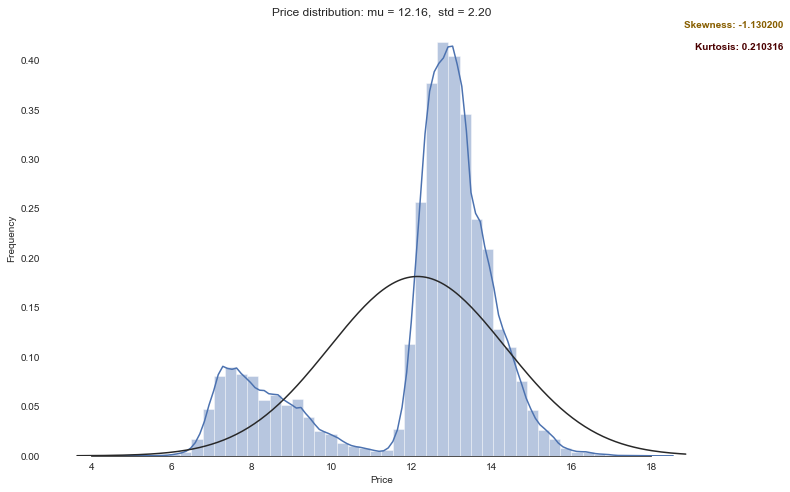

In [22]:
# Visualizando informações de distribuicao da variavel price
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(train["price_log"])

# Verificando a distribuicao de frequencia da variavel PRICE
sns.distplot(train["price_log"], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Price")
ax.set(title="Price distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % train["price_log"].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % train["price_log"].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

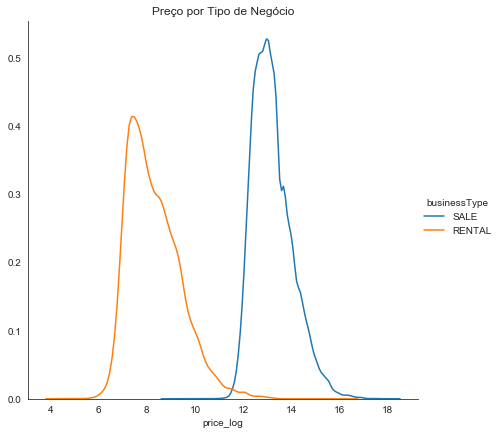

In [23]:
# Com esse grafico de densidade percebe-se que se tipo de negocio for SALE (venda)
# o preco do imovel é superior a preco do imovel para RENTAL (aluguel)
sns.FacetGrid(train, hue="businessType", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Preço por Tipo de Negócio');

In [24]:
# Analise Exploratoria da variavel 'businessType'
# Esta é a variavel que irei utilizar para separar o dataset para obter somente os imoveis de VENDA
# Estou considerando o objetivo do desafio, que é prever o preco de VENDA dos imoveis
train.groupby('businessType').size()

businessType
RENTAL     28632
SALE      105332
dtype: int64

### Observação Importante
De acordo com a informação da distribuição da variavel target (price) e o grafico de densidade de preco por tipo de negocio (venda ou aluguel), vou dividir o dataset considerando o objetivo do desafio e realizando uma analise mais aprofundada
- SALE (imoveis para venda)

In [25]:
# Criando o dataset de imoveis para venda, conforme objetivo do desafio
train_sale = train[(train['businessType'] == 'SALE')]
train_sale.groupby('businessType').size()

businessType
SALE    105332
dtype: int64

In [26]:
# Verificando a quantidade de registros e coluna para o novo dataset
# Exatamente a mesma quantidade dos registros de SALE
train_sale.shape

(105332, 35)

### Análise das demais variaveis do dataset

In [27]:
# Analise Exploratoria da variavel 'city'
train_sale.groupby('city').size()

city
São Paulo    105332
dtype: int64

In [28]:
# Analise Exploratoria da variavel 'acountry'
train_sale.groupby('country').size()

country
BR    105332
dtype: int64

In [29]:
# Analise Exploratoria da variavel 'district'
train_sale.groupby('district').size()

district
Jaraguá        10
Jaçanã          2
None       105320
dtype: int64

In [30]:
# Analise Exploratoria da variavel 'precision'
train_sale.groupby('precision').size()

precision
APPROXIMATE            5753
GEOMETRIC_CENTER      30595
NO_GEOCODE               33
RANGE_INTERPOLATED    11997
ROOFTOP               56954
dtype: int64

In [31]:
# Analise Exploratoria da variavel 'state'
train_sale.groupby('state').size()

state
SP                   241
Santa Catarina         1
São Paulo         105090
dtype: int64

In [32]:
# Analise Exploratoria da variavel 'estado'
train_sale.groupby('estado').size()

estado
Atibaia                     1
Diadema                     1
Guaruja                     1
Guarulhos                   1
Itu                         2
Itupeva                     1
Mogi das Cruzes             1
Osasco                     10
Santana de Parnaiba         1
Santo Andre                 1
Sao Paulo              105309
Taboao da Serra             1
Vinhedo                     2
dtype: int64

In [33]:
# Analise Exploratoria da variavel 'zone'
train_sale.groupby('zone').size()

zone
Centro         2006
None          91793
Zona Leste     2646
Zona Norte     3435
Zona Oeste     1845
Zona Sul       3607
dtype: int64

In [34]:
# Analise Exploratoria da variavel 'listingStatus'
train_sale.groupby('listingStatus').size()

listingStatus
ACTIVE    105332
dtype: int64

In [35]:
# Analise Exploratoria da variavel 'owner'
train_sale.groupby('owner').size()

owner
False    105301
True         31
dtype: int64

In [36]:
# Analise Exploratoria da variavel 'period'
train_sale.groupby('period').size()

period
MONTHLY       419
NONE       104913
dtype: int64

In [37]:
# Analise Exploratoria da variavel 'publicationType'
train_sale.groupby('publicationType').size()

publicationType
PREMIUM       1746
STANDARD    103586
dtype: int64

Text(0.5, 1.0, 'Distribuição por qtde de Banheiros')

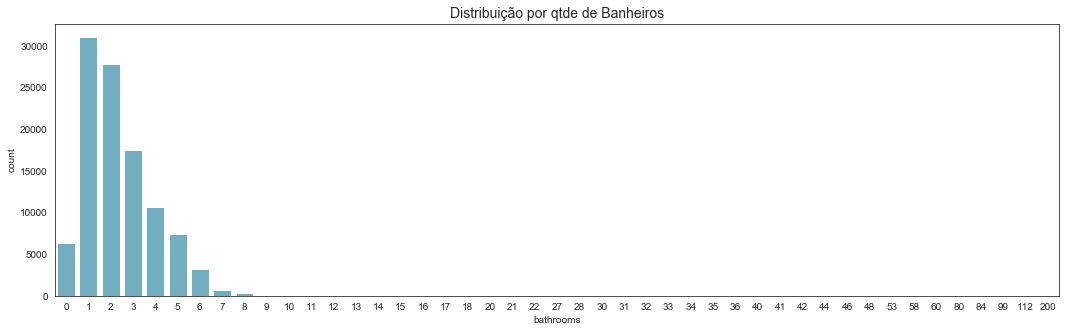

In [38]:
# Analise Exploratoria da variavel 'bathrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='bathrooms', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Banheiros', fontsize=14)

Text(0.5, 1.0, 'Distribuição por qtde de Quartos')

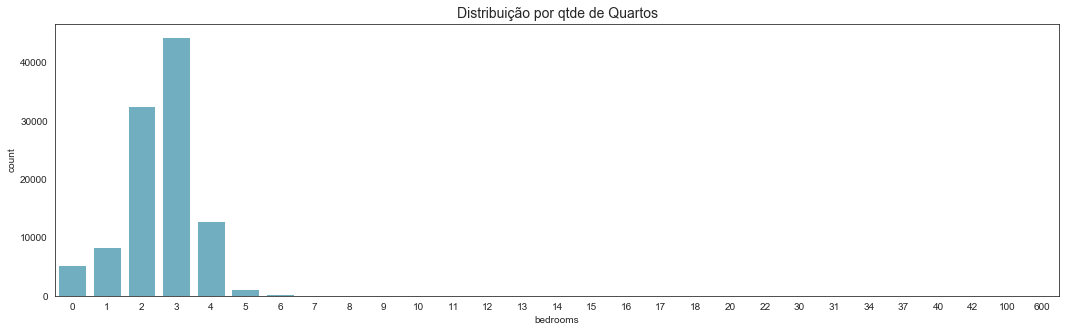

In [39]:
# Analise Exploratoria da variavel 'bedrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='bedrooms', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Quartos', fontsize=14)

Text(0.5, 1.0, 'Distribuição por qtde de Suites')

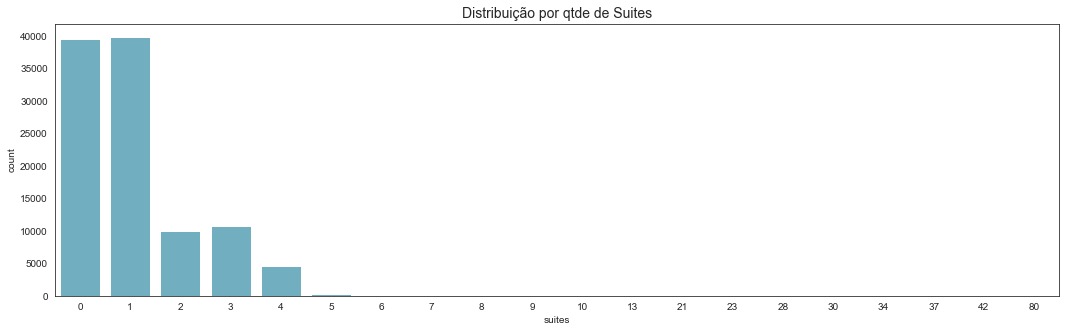

In [40]:
# Analise Exploratoria da variavel 'bedrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='suites', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Suites', fontsize=14)

Text(0.5, 1.0, 'Distribuição por Espaço de Garagem')

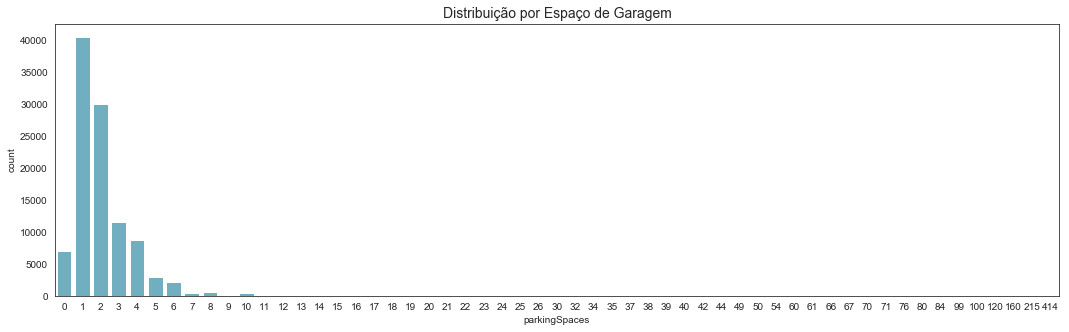

In [41]:
# Analise Exploratoria da variavel 'parkingSpaces'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='parkingSpaces', data=train_sale, color='c')
ax.set_title('Distribuição por Espaço de Garagem', fontsize=14)

Text(0.5, 1.0, 'Distribuição por Tipos de Imóveis')

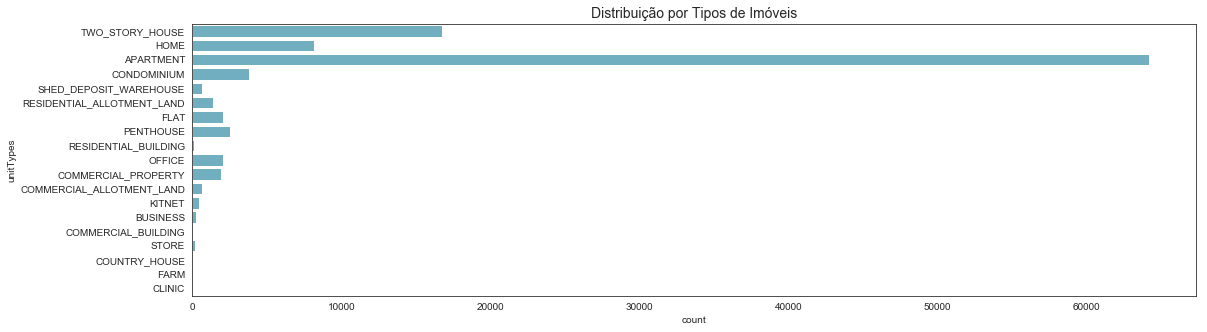

In [42]:
# Analise Exploratoria da variavel 'unitTypes'
# É possivel visualizar claramente que a quantidade 
# de apartamentos a venda é bem superior aos demais tipos de imóveis
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(y='unitTypes', data=train_sale, color='c')
ax.set_title('Distribuição por Tipos de Imóveis', fontsize=14)

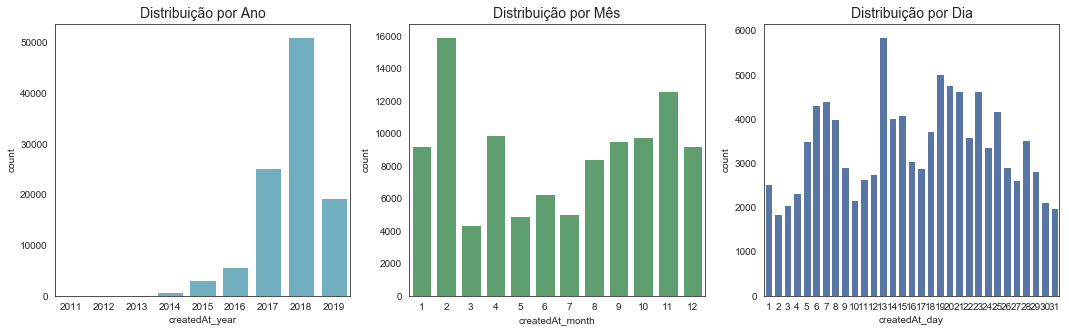

In [43]:
# Analise Exploratoria das variavel criadas a partir da coluna 'createdAt'
f, ax = plt.subplots(1,3, figsize=(18, 5))

# Aqui é possível observar que os anos de 2017, 2018 e 2019 tem um volume maior de registros,
# sendo que o ano de 2018 se destaca
sns.countplot(train_sale['createdAt_year'], color='c', ax=ax[0])
ax[0].set_title('Distribuição por Ano', fontsize=14)

# Aqui é possível observar uma quantidade maior de imóveis cadastrados a partir do segundo semestre, 
# no entanto, um destaque para o mes de fevereiro
sns.countplot(train_sale['createdAt_month'], color='g', ax=ax[1])
ax[1].set_title('Distribuição por Mês', fontsize=14)

sns.countplot(train_sale['createdAt_day'], color='b', ax=ax[2])
ax[2].set_title('Distribuição por Dia', fontsize=14)

f.show()

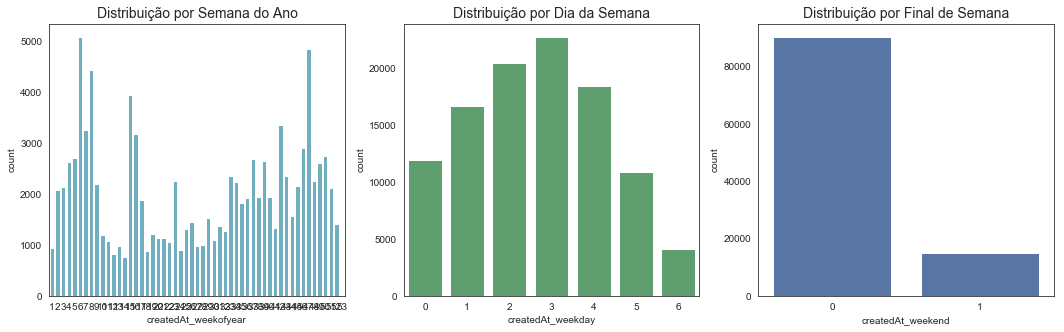

In [44]:
# Analise Exploratoria das variavel criadas a partir da coluna 'createdAt'
f, ax = plt.subplots(1,3, figsize=(18, 5))

# É possível verificar alguns picos no inicio do ano e no final do ano
sns.countplot(train_sale['createdAt_weekofyear'], color='c', ax=ax[0])
ax[0].set_title('Distribuição por Semana do Ano', fontsize=14)

# É possível verificar uma alta taxa de cadastro de imoveis no meio da semana (terca, quarta e quinta)
sns.countplot(train_sale['createdAt_weekday'], color='g', ax=ax[1])
ax[1].set_title('Distribuição por Dia da Semana', fontsize=14)

# Muitos registros foram criados durante a semana
sns.countplot(train_sale['createdAt_weekend'], color='b', ax=ax[2])
ax[2].set_title('Distribuição por Final de Semana', fontsize=14)

f.show()

### Relacionamento do preço de venda dos imóveis com outras features

In [45]:
# Verificar os bairros com preco de venda acima de 10.000.000
q1 = """SELECT bairro, round(max(price),2) 
          FROM train_sale
         GROUP BY bairro 
         HAVING max(price) >= 5000000"""
print(ps.sqldf(q1, locals()))

                            bairro  round(max(price),2)
0                        Aclimacao            7000000.0
1                      Agua Branca           49000000.0
2                        Agua Rasa            5600000.0
3                Alto Da Boa Vista            7065380.0
4                    Alto da Mooca           14972159.0
5                Alto de Pinheiros           56000000.0
6                      Barra Funda            5600000.0
7                       Bela Vista           41993000.0
8                       Belenzinho           41993000.0
9                          Boacava            8904000.0
10                            Bras           23450000.0
11                        Brooklin           11550000.0
12                         Butanta           41993000.0
13                   CIDADE JARDIM           21000000.0
14                         Cambuci           35000000.0
15                      Campo Belo           11944800.0
16                        Cangaiba           372

In [46]:
# Verificar os bairros com preco de venda acima de 5.000.000 com quantidade de registros igual a 1
# Estes registros 'podem' ser caracterizados como problemas nos dados
q1 = """SELECT bairro, count()
          FROM train_sale
         WHERE price >= 5000000
        GROUP BY bairro
        HAVING COUNT() = 1"""
print(ps.sqldf(q1, locals()))

                           bairro  count()
0                       Agua Rasa        1
1                   Alto da Mooca        1
2                        Cangaiba        1
3                         Catumbi        1
4              Chacara California        1
5                 Chacara Inglesa        1
6                 Chacara Jaragua        1
7   Cidade Satelite Santa Barbara        1
8                 Fazenda Morumbi        1
9                  Freguesia do O        1
10                     Guaianases        1
11                       Ipiranga        1
12                      Itaberaba        1
13                 Itaim Paulista        1
14     Jardim Arpoador Zona Oeste        1
15             Jardim Bonfiglioli        1
16                Jardim Britania        1
17                  Jardim Guanca        1
18    Jardim Jaragua Sao Domingos        1
19                  Jardim Leonor        1
20               Jardim Matarazzo        1
21         Jardim Nova Vitoria II        1
22         

In [47]:
# Removendo os registros com preco acima de 5.000.000
# e que so tem um imovel no bairro com esse valor
#train.drop(train[(train['price'] > 5000000)].index, inplace=True)
#train.drop(train[(train['OverallQual']<5) & (train['price']>200000)].index, inplace=True)
#train.reset_index(drop=True, inplace=True)

In [48]:
# Criando uma classe para trabalhar com gráfico de mapa usando o pacote folium
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4",
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix()
        curr_map.add_children(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [49]:
# Analisando a media de preco por bairro (considerando imoveis para venda)
# É possível verificar que a média de preço de venda está bem distribuída entre todos os bairros de São Paulo
dfMediaPorBairroVenda = np.floor(train_sale.groupby('bairro')['price_log'].agg('mean'))
dfMediaPorBairroVenda.name = 'price_log'

# Criando um dataset temporario com o agrupamento da media para plotar no mapa
tmp = pd.merge(left=train_sale[['bairro','latitude','longitude']],
               right=dfMediaPorBairroVenda.to_frame(),
               how='outer',
               left_on='bairro',
               right_index=True)
tmp = tmp.rename(columns={"bairro": "name"})
tmp['price_log'] = tmp['price_log'].fillna(value=0)

# Removendo valores duplicados
tmp.drop_duplicates(keep=False,inplace=True) 

# Plot do mapa de calor por preco x bairro
map_points(tmp, 
           plot_points=False, 
           draw_heatmap=True, 
           heat_map_weights_normalize=False,
           heat_map_weights_col='price_log',
           heat_map_radius=9)

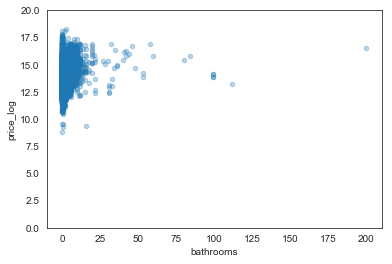

In [50]:
# Relacao do preco do imovel com a quantidade de banheiros
# Percebe-se que existem alguns outliers (ex. de quantidade de banheiros acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['bathrooms']], axis=1)
data.plot.scatter(x='bathrooms', y='price_log', alpha=0.3, ylim=(0,20));

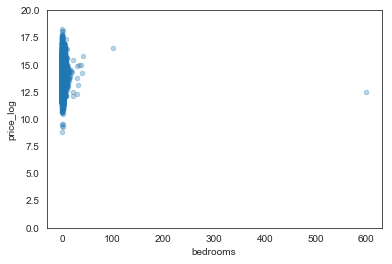

In [51]:
# Relacao do preco do imovel com a quantidade de quartos
# Percebe-se que existem alguns outliers (ex. de quantidade de quartos acima de 600)
data = pd.concat([train_sale['price_log'], train_sale['bedrooms']], axis=1)
data.plot.scatter(x='bedrooms', y='price_log', alpha=0.3, ylim=(0,20));

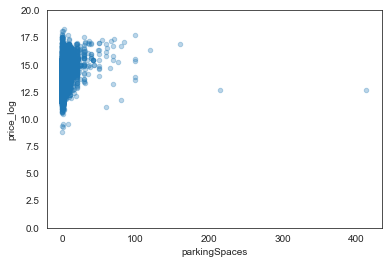

In [52]:
# Relacao do preco do imovel com a quantidade de vagas de garagem
# Percebe-se que existem alguns outliers (ex. de quantidade de vagas de garagem acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['parkingSpaces']], axis=1)
data.plot.scatter(x='parkingSpaces', y='price_log', alpha=0.3, ylim=(0,20));

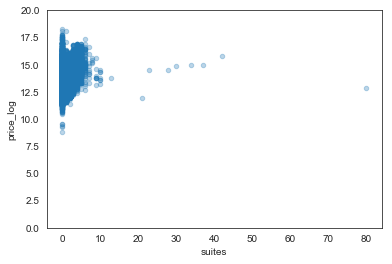

In [53]:
# Relacao do preco do imovel com a quantidade de vagas de garagem
# Percebe-se que existem alguns outliers (ex. de quantidade de vagas de garagem acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['suites']], axis=1)
data.plot.scatter(x='suites', y='price_log', alpha=0.3, ylim=(0,20));

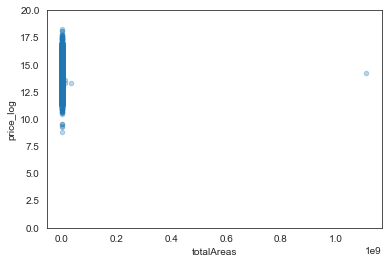

In [54]:
# Relacao do preco do imovel com o total da area
# Percebe-se que existem alguns outliers
data = pd.concat([train_sale['price_log'], train_sale['totalAreas']], axis=1)
data.plot.scatter(x='totalAreas', y='price_log', alpha=0.3, ylim=(0,20));

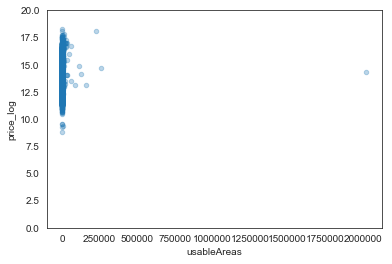

In [55]:
# Relacao do preco do imovel com o total da area util
# Percebe-se que existem alguns outliers
data = pd.concat([train_sale['price_log'], train_sale['usableAreas']], axis=1)
data.plot.scatter(x='usableAreas', y='price_log', alpha=0.3, ylim=(0,20));

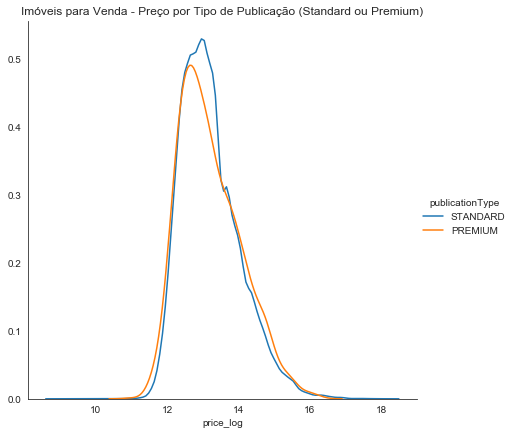

In [56]:
# Com esse grafico de densidade percebe-se que se os precos para o tipo
# Standard e Premium são bem parecidos
sns.FacetGrid(train_sale, hue="publicationType", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Imóveis para Venda - Preço por Tipo de Publicação (Standard ou Premium)');

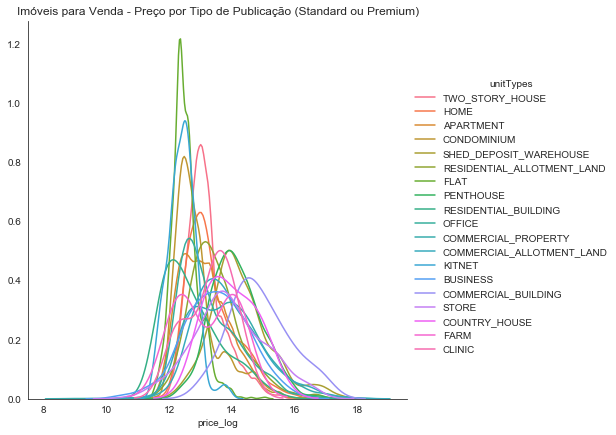

In [57]:
# Com esse grafico de densidade percebe-se que se os precos estão bem lineares por tipo de unidade
sns.FacetGrid(train_sale, hue="unitTypes", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Imóveis para Venda - Preço por Tipo de Publicação (Standard ou Premium)');

# Feature Engineering

In [58]:
# Fazendo uma limpeza na memoria
gc.collect()

31015

In [59]:
# Removendo algumas colunas do dataset que identifiquei como não necessárias para o modelo
train_sale.drop(columns = ["city",
                           "country",
                           "listingStatus",
                           "businessType",
                           "rentalTotalPrice",
                           "period",
                           "price_log"
                          ], inplace = True) 

### Encoding Categorical Variables

Label encoding: atribua cada categoria exclusiva em uma variável categórica com um inteiro. Nenhuma nova coluna é criada.

In [60]:
# Cria um label encoder object
le = LabelEncoder()
le_count = 0

# Iteracao para cada coluna do dataset
for col in train_sale:
    if train_sale[col].dtype == 'object':
        le.fit_transform(train_sale[col].astype(str))
        train_sale[col] = le.transform(train_sale[col])
        le_count += 1

In [61]:
# Convertendo algumas variaveis  para inteiro
train_sale['bathrooms'] = train_sale['bathrooms'].astype(int)
train_sale['bedrooms'] = train_sale['bedrooms'].astype(int)
train_sale['parkingSpaces'] = train_sale['parkingSpaces'].astype(int)
train_sale['suites'] = train_sale['suites'].astype(int)

### Criando algumas novas colunas

Os modelos de Machine Learning têm dificuldade em reconhecer padrões mais complexos. Então vou criar alguns recursos baseados em minha intuição sobre o conjunto de dados.

In [62]:
# Nova coluna para identificar se o imóvel tem estacionamento
train_sale['hasparkingSpaces'] = train_sale['parkingSpaces'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) banheiro
train_sale['hasbathrooms'] = train_sale['bathrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) quarto
train_sale['hasbedrooms'] = train_sale['bedrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos uma (1) suíte
train_sale['hassuites'] = train_sale['suites'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna que identifica a soma das taxas obrigatórias como taxa do condominio e IPTU
train_sale['totalFee'] = train_sale['monthlyCondoFee'] * train_sale['yearlyIptu']

In [63]:
# Analisando o dataset após aplicar feature enginnering
train_sale.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,price,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,estado,bairro,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee
0,2,-23.612923,-46.614222,4,761,2,9319,5,3,4,False,6,0.0,700000,0.0,1,1,388.0,18,388.0,7,2,2017,6,1,0,10,535,1,1,1,1,0.0
1,2,-23.643962,-46.593475,3,1460,2,8955,5,2,3,False,2,0.0,336000,0.0,1,1,129.0,10,129.0,21,3,2016,12,0,0,10,915,1,1,1,1,0.0
3,2,-23.598023,-46.682781,3,1383,2,10012,1,2,3,False,2,686.0,739643,1610.0,1,1,80.0,0,80.0,26,10,2018,43,4,0,10,976,1,1,1,1,1104460.0
4,2,-23.582497,-46.653027,3,860,2,7827,1,5,4,False,5,6230.0,7520099,18900.0,1,4,332.0,0,3322.0,14,12,2018,50,4,0,10,593,1,1,1,1,117747000.0
6,2,-23.561318,-46.686355,4,969,2,12377,1,1,3,False,2,1120.0,630700,489.0,1,0,0.0,0,94.0,29,5,2018,22,1,0,10,675,1,1,1,0,547680.0


### Feature transformations

Vou criar mais colunas calculando as transformações de log e quadrado de algumas features numéricas. Vou fazer isso manualmente, porque alguns modelos de Machine Learning não dizem com segurança se log (feature) ou feature^2 é um preditor do Preco.

In [64]:
# Realizando uma transformacao logaritma na variavel price
# Isso irá melhorar a acuracia do modelo de machine learning
train_sale["price"] = np.log1p(train_sale["price"])

In [65]:
# Procedimento para criar novas colunas aplicando função logarítma nos campos numéricos escolhidos
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['monthlyCondoFee',
                'yearlyIptu',
                'totalAreas',
                'usableAreas',
                'totalFee']

train_sale = logs(train_sale, log_features)

In [66]:
# Procedimento para criar novas colunas aplicando função quadrática nos campos numéricos escolhidos
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['monthlyCondoFee_log', 
                    'yearlyIptu_log',
                    'totalAreas_log', 
                    'usableAreas_log', 
                    'totalFee_log']

train_sale = squares(train_sale, squared_features)

In [67]:
# Com a criação das novas colunas, alguns valores inf e nan também foram criados, sendo necessário este tratamento
# Neste caso, estou aplicando o valor 0 (zero) para eles
train_sale = train_sale.replace([np.inf, -np.inf], np.nan)
train_sale.update(train_sale.fillna(0))

In [68]:
# Analisando o dataset após aplicar feature transformation
train_sale.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,price,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,estado,bairro,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee,monthlyCondoFee_log,yearlyIptu_log,totalAreas_log,usableAreas_log,totalFee_log,monthlyCondoFee_log_sq,yearlyIptu_log_sq,totalAreas_log_sq,usableAreas_log_sq,totalFee_log_sq
0,2,-23.612923,-46.614222,4,761,2,9319,5,3,4,False,6,0.0,13.458837,0.0,1,1,388.0,18,388.0,7,2,2017,6,1,0,10,535,1,1,1,1,0.0,0.009950,0.009950,5.963605,5.963605,0.009950,0.000099,0.000099,35.564585,35.564585,0.000099
1,2,-23.643962,-46.593475,3,1460,2,8955,5,2,3,False,2,0.0,12.724869,0.0,1,1,129.0,10,129.0,21,3,2016,12,0,0,10,915,1,1,1,1,0.0,0.009950,0.009950,4.867611,4.867611,0.009950,0.000099,0.000099,23.693640,23.693640,0.000099
3,2,-23.598023,-46.682781,3,1383,2,10012,1,2,3,False,2,686.0,13.513924,1610.0,1,1,80.0,0,80.0,26,10,2018,43,4,0,10,976,1,1,1,1,1104460.0,6.532349,7.384617,4.394573,4.394573,13.914868,42.671581,54.532562,19.312268,19.312268,193.623551
4,2,-23.582497,-46.653027,3,860,2,7827,1,5,4,False,5,6230.0,15.833090,18900.0,1,4,332.0,0,3322.0,14,12,2018,50,4,0,10,593,1,1,1,1,117747000.0,8.737294,9.846971,5.808173,8.108626,18.584049,76.340302,96.962831,33.734868,65.749820,345.366871
6,2,-23.561318,-46.686355,4,969,2,12377,1,1,3,False,2,1120.0,13.354587,489.0,1,0,0.0,0,94.0,29,5,2018,22,1,0,10,675,1,1,1,0,547680.0,7.021985,6.194426,0.009950,4.553982,13.213448,49.308278,38.370911,0.000099,20.738753,174.595216


## Verificando a correlação entre as variaveis após aplicar feature engineering e transformation

### Correlação
A correlação é o relacionamento entre 2 variáveis. O método mais comum para calcular correlação é o método de Pearson, que assume uma distribuição normal dos dados. Correlação de -1 mostra uma correlação negativa, enquanto uma correlação de +1 mostra uma correlação positiva. Uma correlação igual a 0 mostra que não há relacionamento entre as variáveis.

Alguns algoritmos de machine learning podem apresentar problemas de performance se houver atributos altamente correlacionados (colineares).

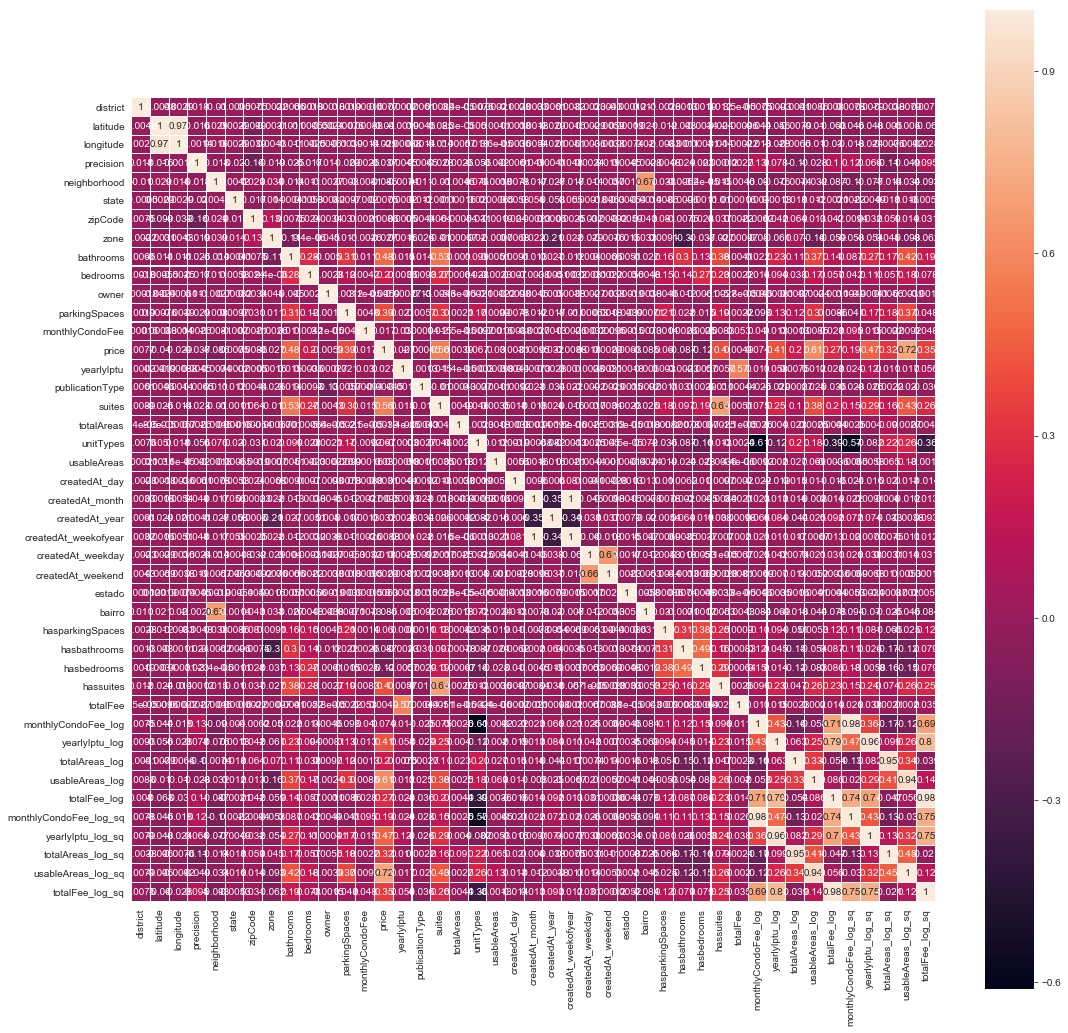

In [69]:
# Correlação de Pearson
cor_mat = train_sale.corr(method = 'pearson')

# Visualizando o grafico de heatmap
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cor_mat,linewidths=.1,ax=ax,square=True,cbar=True,annot=True)

### Skew
Skew (ou simetria) se refere a distribuição dos dados que é assumida ser normal ou gaussiana (bell curve). Muitos algoritmos de Machine Learning consideram que os dados possuem uma distribuição normal. Conhecendo a simetria dos dados, permite preparar e entregar o que o algoritmo espera receber, aumentado desta forma a acurácia do modelo preditivo.

In [70]:
# Verificando o skew de cada atributo
train_sale.skew()

district                  -97.759315
latitude                   95.418662
longitude                  99.437820
precision                  -0.610940
neighborhood               -0.300784
state                     -20.812776
zipCode                     0.092524
zone                        3.113004
bathrooms                  19.179501
bedrooms                  199.040266
owner                      58.265800
parkingSpaces              46.896033
monthlyCondoFee           257.921119
price                       0.823688
yearlyIptu                189.775230
publicationType            -7.572720
suites                      4.776680
totalAreas                324.022661
unitTypes                   0.909603
usableAreas               302.380923
createdAt_day              -0.066613
createdAt_month            -0.071172
createdAt_year             -1.143795
createdAt_weekofyear       -0.061313
createdAt_weekday           0.091524
createdAt_weekend           2.048650
estado                    -97.395949
b

# Feature Selection - Método Ensemble

As variaveis (atributos) presentes nos dados de treino tem grande influência na precisão e resultado do modelo preditivo. Atributos irrelevantes terão impacto negativo na performance, enquanto atributos colineares podem afetar o grau de acurácia do modelo. O Scikit-learn possui funções que automatizam o trabalho de extração e seleção de variáveis.

A etapa de Feature Selection é onde selecionamos as variaveis (atributos) que serão melhores candidatas a variáveis preditoras. O Feature Selection nos ajuda a reduzir o overfitting (quando o algoritmo aprende demais), aumenta a acurácia do modelo e reduz o tempo de treinamento.

Bagged Decision Trees, como o algoritmo RandomForest (esses são chamados de Métodos Ensemble), podem ser usados para estimar a importância de cada atributo. Esse método retorna um score para cada atributo. Quanto maior o score, maior a importância do atributo.

In [71]:
# Importância do Atributo com o Extra Trees Classifier

# Split features and labels
X = train_sale.drop(['price'], axis=1)
y = train_sale['price']

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Criação do Modelo - Feature Selection
modeloETC = ExtraTreesRegressor()
modeloETC.fit(X, y)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(train_sale.columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloETC.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

                   Feature  importance
35          totalAreas_log    0.184176
40       totalAreas_log_sq    0.138306
30             hasbedrooms    0.085647
32                totalFee    0.056065
11           parkingSpaces    0.049721
37            totalFee_log    0.047922
34          yearlyIptu_log    0.038907
2                longitude    0.038174
17              totalAreas    0.037724
18               unitTypes    0.035265
38  monthlyCondoFee_log_sq    0.034316
36         usableAreas_log    0.031697
1                 latitude    0.025215
39       yearlyIptu_log_sq    0.018641
29            hasbathrooms    0.017563
33     monthlyCondoFee_log    0.017502
12         monthlyCondoFee    0.016928
6                  zipCode    0.016581
15         publicationType    0.012576
9                 bedrooms    0.012244
41      usableAreas_log_sq    0.011929
26                  estado    0.008385
4             neighborhood    0.008318
16                  suites    0.007942
8                bathroom

Visualizando a importancia das variaveis

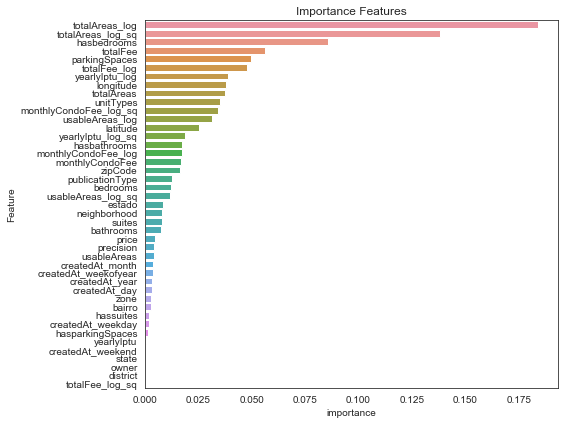

In [72]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:43].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

In [73]:
# Removendo algumas colunas do dataset com baixissima colinearidade
train_sale.drop(columns = ["totalFee",
                           "district", 
                           "owner",
                           "createdAt_weekend",
                           "state"
                          ], inplace = True) 

# Criação e Validação dos Modelos de Machine Learning

## Algumas considerações deste processo:
- **Cross Validation:** Estou usando 5-fold cross-validation
- **Models:** Em cada passada do cross-validation eu treino 4 modelos (gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** Eu também treinei um modelo StackingCVRegressor otimizado usando xgboost

In [74]:
# Fazendo uma limpeza na memoria
gc.collect()

19768

Normalização e Padronização de features numericas

In [75]:
# Split features and labels
X = train_sale.drop(['price'],axis=1)
y = train_sale['price']

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

In [76]:
# Verificando o shape apos o split entre feature e target
# São 105.332 registros e 42 colunas
X.shape, y.shape

((105332, 37), (105332,))

In [77]:
# Setup cross validation folds
kf = KFold(n_splits=2, random_state=42, shuffle=True)
scoresRMSLE = {}
scoresR2 = {}

### Root Mean Squared Error (RMSE)

Essa é uma excelente métrica para modelos de regressão, além de ser muito fácil de interpretar. A Raiz Quadrada do Erro Quadrático Médio — ou simplesmente RMSE em inglês — nada mais é que a diferença entre o valor que foi previsto pelo seu modelo e o valor real que foi observado.
Por exemplo, imagine que você está construindo um modelo para prever preço de casas. Esse modelo deveria ter previsto o valor de 100 mil para um exemplo no seu conjunto, mas ele previu 99 mil: esse -1 mil de diferença é o erro do seu modelo. Agora é só repetir esse processo para todo seu conjunto de treino ou teste, elevar o erro ao quadrado, tirar a média de todos os valores do conjunto e, por fim, calcular a raiz quadrada.

In [78]:
# Defini a metrica de validacao (RMSE)
def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# Defini a metrica de validacao (R2)
def cv_r2(model, X, y):
    r2 = cross_val_score(model, X, y, scoring='r2', cv=kf)
    return (r2)

Nessa parte adicionei varios modelos para comparacao. A principio utilizei os parametros default de cada modelo.

In [79]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor()

# XGBoost Regressor
xgboost = XGBRegressor(objective='reg:squarederror')

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()  

# Random Forest Regressor
rf = RandomForestRegressor()

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lightgbm, xgboost, gbr, rf),
                                meta_regressor=xgboost,
                                random_state=12345,
                                use_features_in_secondary=True)


In [81]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(lightgbm, X, y)
print("RMSE lightgbm: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['lgb'] = (resRMSE.mean(), resRMSE.std())

# Verificando a acuracia com a métrica R2
resR2 = cv_r2(lightgbm, X, y)
print("R2 lightgbm: {:.4f} ({:.4f})".format(resR2.mean(), resR2.std()))
scoresR2['lgb'] = (resR2.mean(), resR2.std())

RMSE lightgbm: 0.2669 (0.0014)
R2 lightgbm: 0.8958 (0.0009)


In [82]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(xgboost, X, y)
print("RMSE xgboost: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['xgb'] = (resRMSE.mean(), resRMSE.std())

# Verificando a acuracia com a métrica R2
resR2 = cv_r2(xgboost, X, y)
print("R2 xgboost: {:.4f} ({:.4f})".format(resR2.mean(), resR2.std()))
scoresR2['xgb'] = (resR2.mean(), resR2.std())

RMSE xgboost: 0.3055 (0.0001)
R2 xgboost: 0.8635 (0.0001)


In [83]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(gbr, X, y)
print("RMSE gbr: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['gbr'] = (resRMSE.mean(), resRMSE.std())

# Verificando a acuracia com a métrica R2
resR2 = cv_r2(gbr, X, y)
print("R2 gbr: {:.4f} ({:.4f})".format(resR2.mean(), resR2.std()))
scoresR2['gbr'] = (resR2.mean(), resR2.std())

RMSE gbr: 0.3039 (0.0022)
R2 gbr: 0.8649 (0.0017)


In [ ]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(rf, X, y)
print("RMSE rf: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['rf'] = (resRMSE.mean(), resRMSE.std())

# Verificando a acuracia com a métrica R2
resR2 = cv_r2(rf, X, y)
print("R2 rf: {:.4f} ({:.4f})".format(resR2.mean(), resR2.std()))
scoresR2['rf'] = (resR2.mean(), resR2.std())

RMSE rf: 0.2720 (0.0029)
R2 rf: 0.8920 (0.0005)


In [ ]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(stack_gen, X, y)
print("RMSE stack_gen: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['stack_gen'] = (resRMSE.mean(), resRMSE.std())

# Verificando a acuracia com a métrica R2
resR2 = cv_r2(stack_gen, X, y)
print("R2 stack_gen: {:.4f} ({:.4f})".format(resR2.mean(), resR2.std()))
scoresR2['stack_gen'] = (resR2.mean(), resR2.std())


# Menor valor, considerando separar o dataset pelo tipo de imovel
#stack_gen: 0.2485 (0.0029)

# Valor com o dataset de treino e com a criacao de novas variaveis e sem tratar os outliers
# stack_gen: 0.2253 (0.0049)

RMSE stack_gen: 0.2573 (0.0020)


# Otimização dos Modelos - Ajuste de Parâmetros

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
 
print(X_train.shape, ' train samples shape')
print(X_test.shape, ' test samples shape')

### Random Search

In [ ]:
est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=12345)

hyper_space = {'n_estimators': sp_randint(1000, 2500),
               'max_depth':  [4, 5, 8, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': sp_uniform(0.6, 0.4),
               'colsample_bytree': sp_uniform(0.6, 0.4)}

rs = RandomizedSearchCV(est, hyper_space, n_iter=60, scoring='r2', cv=kf, verbose=1)
rs_results = rs.fit(X_train, y_train)
print("BEST PARAMETERS: " + str(rs_results.best_params_))
print("BEST CV SCORE: " + str(rs_results.best_score_))
 
# Predict (after fitting RandomizedSearchCV is an estimator with best parameters)
y_pred = rs.predict(X_test)
 
# Score
score = r2_score(y_test, y_pred)
print("R2 SCORE ON TEST DATA: {}".format(score))


#BEST PARAMETERS: {'colsample_bytree': 0.8072394162276869, 'max_depth': -1, 'n_estimators': 1290, 'num_leaves': 127, 'subsample': 0.8368967019276977}
#BEST CV SCORE: 0.989769536531592
#R2 SCORE ON TEST DATA: 0.9907524704263416

### Tree-structured Parzen Estimator

In [ ]:
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval
 
# Define searched space
#hyper_space = {'n_estimators': 1000 + hp.randint('n_estimators', 1500),
#               'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
#               'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
#               'subsample': hp.uniform('subsample', 0.6, 1.0),
#               'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)}

hyper_space_tree = {'choices': hp.choice('choices', [
                                {'learning_rate': 0.01, 
                                 'n_estimators': hp.randint('n_estimators_small_lr', 1500)},
                                {'learning_rate': 0.1, 
                                 'n_estimators': 1000 + hp.randint('n_estimators_medium_lr', 1500)}
                                ]),
                    'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
                    'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
                    'subsample': hp.uniform('subsample', 0.6, 1.0),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)}

In [ ]:
def evaluate(params, X, y):
    
    # Initilize instance of estimator
    est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=2019)
    
    # Set params
    est.set_params(**params)
    
    # Calc CV score
    scores = cross_val_score(estimator=est, X=X, y=y, scoring='r2', cv=kf)
    score = np.mean(scores)
 
    return score
 
# Objective minimized 
hyperopt_objective = lambda params: (-1.0) * evaluate(params, X_train, y_train)

In [ ]:
# Trail
trials = Trials()
 
# Set algoritm parameters
algo = partial(tpe.suggest, n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# Fit Tree Parzen Estimator
best_vals = fmin(hyperopt_objective, 
                 space=hyper_space_tree,
                 algo=algo, 
                 max_evals=60, 
                 trials=trials,
                 rstate=np.random.RandomState(seed=12345))
 
# Print best parameters
best_params = space_eval(hyper_space_tree, best_vals)
print("BEST PARAMETERS: " + str(best_params))
 
# Print best CV score
scores = [-trial['result']['loss'] for trial in trials.trials]
print("BEST CV SCORE: " + str(np.max(scores)))
 
# Print execution time
tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))


#100%|██████████| 60/60 [56:34<00:00, 52.39s/it, best loss: -0.989734255698029]  
#BEST PARAMETERS: {'colsample_bytree': 0.7553443440144287, 'max_depth': -1, 'n_estimators': 1096, 'num_leaves': 127, 'subsample': 0.6926155728675226}
#BEST CV SCORE: 0.989734255698029
#ELAPSED TIME: 55.8988

In [ ]:
# Set params
est.set_params(**best_params)
 
# Fit    
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
 
# Predict
score = r2_score(y_test, y_pred)
print("R2 SCORE ON TEST DATA: {}".format(score))

#R2 SCORE ON TEST DATA: 0.9907330923837975

# Visualizando a performance dos modelos

In [ ]:
# Plot com a previsao de cada modelo usando a metrica RMSLE
sns.set_style("white")
fig = plt.figure(figsize=(12, 6))

ax = sns.pointplot(x=list(scoresRMSLE.keys()), y=[resRMSE for resRMSE, _ in scoresRMSLE.values()], markers=['o'], linestyles=['-'])
for i, resRMSE in enumerate(scoresRMSLE.values()):
    ax.text(i, resRMSE[0] , '{:.6f}'.format(resRMSE[0]), horizontalalignment='left', color='black', weight='semibold')

plt.ylabel('Score (RMSE)')
plt.xlabel('Model')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.title('Scores of Models (RMSE)')
plt.show()

In [ ]:
# Plot com a previsao de cada modelo usando a metrica R2
sns.set_style("white")
fig = plt.figure(figsize=(12, 6))

ax = sns.pointplot(x=list(scoresR2.keys()), y=[resR2 for resR2, _ in scoresR2.values()], markers=['o'], linestyles=['-'])
for i, resR2 in enumerate(scoresR2.values()):
    ax.text(i, resR2[0] , '{:.6f}'.format(resR2[0]), horizontalalignment='left', color='black', weight='semibold')

plt.ylabel('Score (R2)')
plt.xlabel('Model')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.title('Scores of Models (R2)')
plt.show()

Podemos observar nos gráficos de comparacao acima que o modelo RandomForestRegressor Otimizado tem a melhor performance, com um RMSLE de 0,2372. Este é o modelo que usarei para fazer as previsões finais.

# Trabalhando com o dataset de Teste

In [ ]:
with open('data/source-4-ds-test.json') as file_data:
    data = file_data.readlines()

test = json_normalize([json.loads(d) for d in data])

In [ ]:
test.set_index('id',inplace=True)

In [ ]:
test.shape

Aplicando as mesmas feature enginnering no dataset de test (deixando as mesmas features e nos mesmos formatos)

In [ ]:
test.drop(columns = 'images', inplace = True) 

In [ ]:
test.drop(columns = ["address.city",
                     "address.country", 
                     "address.district", 
                     "address.state", 
                     "listingStatus", 
                     "owner",
                     "address.locationId", 
                     "address.unitNumber",
                     "createdAt", 
                     "description",
                     "publisherId",
                     "title", 
                     "updatedAt",
                     "address.street",
                     "address.streetNumber",
                     "address.zone",
                     "address.neighborhood"
                    ], inplace = True) 

In [ ]:
fill_na(test)

In [ ]:
test['address.zipCode'] = pd.to_numeric(test['address.zipCode'],errors='coerce')

In [ ]:
test = test.replace([np.inf, -np.inf], np.nan)
test.update(test.fillna(0))

In [ ]:
test.head()

In [ ]:
train.tail()

In [ ]:
# Separando o array em componentes de input e output
X_final = test.drop(['pricingInfos.price'], axis=1)

# Aplicando a mesma escala nos dados
X_final = MinMaxScaler().fit_transform(X_final)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_final = StandardScaler().fit_transform(X_final)

In [ ]:
# Fazendo previsões no dataset de teste
previsoes = np.floor(np.expm1(modeloRF_otm.predict(X_final)))

Gerando o arquivo de teste com as colunas 'id' e 'price' (indica a previsao do modelo)

In [ ]:
#Gerando Arquivo de Submissao
submission = pd.DataFrame({
    "id": test.index, 
    "price": previsoes
})

In [ ]:
# Salvando o resultado das previsoes em um arquivo .csv
submission.to_csv('data/test_new.csv', index=False)